# Course Project

## Dataset

You will examine the ProPublica COMPAS dataset, which consists of all criminal defendants who were subject to COMPAS screening in Broward County, Florida, during 2013 and 2014. For each defendant, various information fields (‘features’) were also gathered by ProPublica. Broadly, these fields are related to the defendant’s demographic information (e.g., gender and race), criminal history (e.g., the number of prior offenses) and administrative information about the case (e.g., the case number, arrest date, risk of recidivism predicted by the COMPAS tool). Finally, the dataset also contains information about whether the defendant did actually recidivate or not.

The COMPAS score uses answers to 137 questions to assign a risk score to defendants -- essentially a probability of re-arrest. The actual output is two-fold: a risk rating of 1-10 and a "low", "medium", or "high" risk label.

Link to dataset: https://github.com/propublica/compas-analysis

The file we will analyze is: compas-scores-two-years.csv

Link to the ProPublica article:

https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing


## Project goal

The project has three parts: 

- The COMPAS scores have been shown to have biases against certain racial groups. Analyze the dataset to highlight these biases.  

- Based on the features in the COMPAS dataset, train classifiers to predict who will re-offend (hint: no need to use all features, just the ones you find relevant).  Study if your classifiers are more or less fair than the COMPAS classifier. 

- Build a fair classifier (last lecture will cover fair classification techniques). Is excluding the race from the feature set enough?


## Today

Explore the dataset and do some initial statistics. 

## Download the data

We first need to load the data from the ProPublica repo:
https://github.com/propublica/compas-analysis


In [23]:
import urllib
import os,sys
import numpy as np
import pandas as pd

from sklearn import feature_extraction
from sklearn import preprocessing
from random import seed, shuffle
#from __future__ import division
#from collections import defaultdict
#import utils as ut

SEED = 1234
seed(SEED)
np.random.seed(SEED)

def check_data_file(fname):
    files = os.listdir(".") # get the current directory listing
    print("Looking for file '%s' in the current directory...",fname)

    if fname not in files:
        print("'%s' not found! Downloading from GitHub...",fname)
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        response = urllib.request.urlopen(addr)
        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print("'%s' download and saved locally..",fname)
    else:
        print("File found in current directory..")
    
COMPAS_INPUT_FILE = "compas-scores-two-years.csv"
check_data_file(COMPAS_INPUT_FILE)  

Looking for file '%s' in the current directory... compas-scores-two-years.csv
File found in current directory..


## Load data and clean it up

__Load the data__

hint: data is in csv format; pandas is a python library that can read csv files

you can choose to represent your data either as a DataFrame or as a dictionary

- The dataset contains data on how many convicts? 

- What are the features the dataset contains?

hint pandas: check pandas functions shape, column, head

hint dictionary: check keys() function

__Cleanup the data__

- Are there missing values (NaN)? are there outliers?  

hint pandas: check isnull function in pandas

hint dictionary: implement a for and check if the variable is None

- Does ProPublica mentions how to clean the data?  

__What is the effect of the following function?__

df = pd.read_csv(COMPAS_INPUT_FILE)

print(df.shape)

df = df.dropna(subset=["days_b_screening_arrest"]) # dropping missing vals

df = df[
    (df.days_b_screening_arrest <= 30) &  
    (df.days_b_screening_arrest >= -30) &  
    (df.is_recid != -1) &
    (df.c_charge_degree != 'O') &
    (df.score_text != 'N/A')
]

df.reset_index(inplace=True, drop=True) # renumber the rows from 0 again

## Basic analysis of demographics

- What are the different races present in the dataset? 

- What is the number of people by age category?

- What is the number of people by race?

- What is the number of people by COMPAS score (decile_score)?

- What is the number of people by COMPAS risk category (score_text)?

## Basic investigations of gender and race bias in COMPAS scores

decile_score -- is the score given by the COMPAS algorithm that estimates the risk to re-offend.

score_text -- is the level of risk: Low, Medium, High

two_years_recid -- is the ground truth data on whether the offender recidivated or not

- What is the mean COMPAS score (decile_score) per race and gender? 

- What is the distribution (histogram) of decile_score per race and gender? 

The two_year_recid field records whether or not each person was re-arrested for a violent offense within two years, which is what COMPAS is trying to predict.

- How many people were re-arrested? 

- Compute the recidivism (i.e., people that got re-arrested) rates by race and gender

- What is the accuracy of the COMPAS scores to predict recidivism

- Is the accuracy higher/lower if we look at particular races/genders?

- What about false positives and false negatives?


In [24]:
df = pd.read_csv(COMPAS_INPUT_FILE)
df2 = df.groupby(['juv_other_count']).size()
df2

juv_other_count
0     6691
1      368
2       98
3       33
4       15
5        4
6        1
7        2
9        1
17       1
dtype: int64

In [25]:
df = pd.read_csv(COMPAS_INPUT_FILE)

print(df.shape)

df = df.dropna(subset=["days_b_screening_arrest"]) # dropping missing vals
print(df.shape)
# TODO: find out why we filter like this
df = df[ (df.days_b_screening_arrest <= 30) &
(df.days_b_screening_arrest >= -30) &
(df.is_recid != -1) & (df.c_charge_degree != 'O') & (df.score_text != 'N/A') ]

df.reset_index(inplace=True, drop=True) # renumber the rows from 0 again
print(df.shape)
print(df.columns)


(7214, 53)
(6907, 53)
(6172, 53)
Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')


The dataset contains 7214 entries, after filtering the NaN we obtain 6907 and then, after the other filtering (TODO: understand it), we remain with 6172 entries with 53 columns.

In [26]:
df.groupby(['age_cat']).size()

age_cat
25 - 45            3532
Greater than 45    1293
Less than 25       1347
dtype: int64

In [27]:
df.groupby(['race']).size()

race
African-American    3175
Asian                 31
Caucasian           2103
Hispanic             509
Native American       11
Other                343
dtype: int64

In [28]:
df.groupby(['decile_score']).size()

decile_score
1     1286
2      822
3      647
4      666
5      582
6      529
7      496
8      420
9      420
10     304
dtype: int64

In [29]:
df.groupby(['score_text']).size()

score_text
High      1144
Low       3421
Medium    1607
dtype: int64

In [30]:
df_race_gender = df.groupby(['race', 'sex']).size().reset_index(name = 'count')

df_race_gender


,race,sex,count
0,African-American,Female,549
1,African-American,Male,2626
2,Asian,Female,2
3,Asian,Male,29
4,Caucasian,Female,482
5,Caucasian,Male,1621
6,Hispanic,Female,82
7,Hispanic,Male,427
8,Native American,Female,2
9,Native American,Male,9


In [31]:
df_type_of_misconduct = df.groupby(['v_type_of_assessment']).size().reset_index(name = 'count')
df_type_of_misconduct

,v_type_of_assessment,count
0,Risk of Violence,6172


race
African-American    5.276850
Asian               2.838710
Caucasian           3.635283
Hispanic            3.383104
Native American     6.454545
Other               2.889213
Name: decile_score, dtype: float64

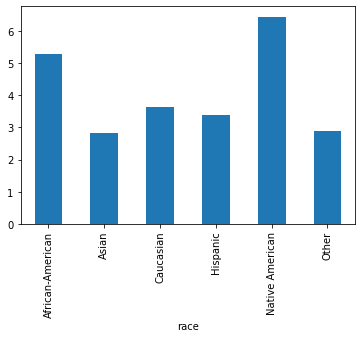

In [32]:
racedf = df.groupby(["race"]).mean()["decile_score"]
racedf.plot.bar()
racedf

sex
Female    4.063830
Male      4.501901
Name: decile_score, dtype: float64

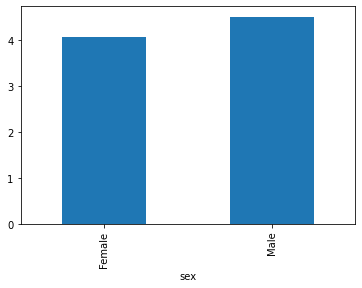

In [33]:
genderdf = df.groupby(["sex"]).mean()["decile_score"]
genderdf.plot.bar()
genderdf


<AxesSubplot:xlabel='decile_score'>

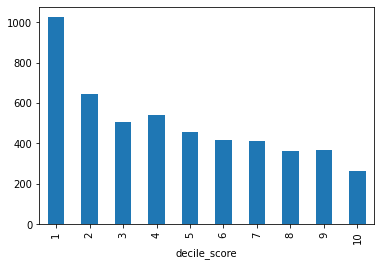

In [34]:
df1 = df[df['sex'] == "Male"].groupby(['decile_score']).size()
df1.plot.bar()


<AxesSubplot:xlabel='decile_score'>

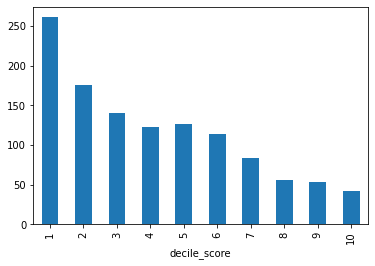

In [35]:
df2 = df[df['sex'] == "Female"].groupby(['decile_score']).size()
df2.plot.bar()

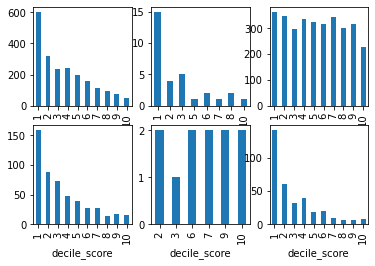

In [36]:

import matplotlib.pyplot as plt 
races = ['Caucasian', 'Asian', 'African-American', 'Hispanic', 'Native American', 'Other']
f, _ax = plt.subplots(nrows=2, ncols=3)
i=0

idx = 0
for i in range(2):
    for j in range(3):
        df2 = df[df['race'] == races[idx] ].groupby(['decile_score']).size()
        df2.plot.bar(ax=_ax[i, j], y=races[i*2+j])
        idx+=1

The COMPAS tool attributed to most races small decile scores, close to 1, except for African American and Native American. While the Native American sample is very small, 11 entries in total, one can see that the decile score attributed to African Americans paints this group to be significantly more dangerous that the others. As such, the data is obviously biased

In [37]:
df.groupby(['two_year_recid']).size()

two_year_recid
0    3363
1    2809
dtype: int64

<AxesSubplot:xlabel='two_year_recid'>

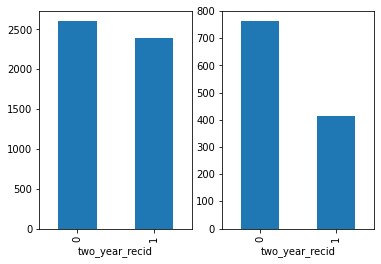

In [38]:
_, _ax = plt.subplots(nrows=1, ncols=2)


df1 = df[df['sex'] == "Male"].groupby(['two_year_recid']).size()
df1.plot.bar(ax=_ax[0])
df2 = df[df['sex'] == "Female"].groupby(['two_year_recid']).size()
df2.plot.bar(ax=_ax[1])

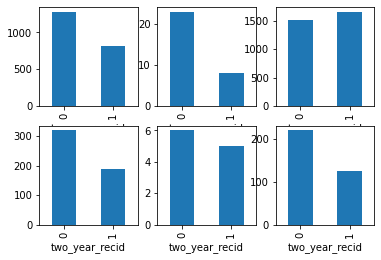

In [39]:

import matplotlib.pyplot as plt 
races = ['Caucasian', 'Asian', 'African-American', 'Hispanic', 'Native American', 'Other']
f, _ax = plt.subplots(nrows=2, ncols=3)
idx = 0
for i in range(2):
    for j in range(3):
        df2 = df[df['race'] == races[idx] ].groupby(['two_year_recid']).size()
        df2.plot.bar(ax=_ax[i, j])
        idx+=1

This score also highlits an important aspect: of all the groups, there is only one who has more positive instances for "recidivated" category and that is the African American group. Given the data, it is obvious that the dataset is biased against this group. 

In [40]:
df['predicted_recid'] = df['decile_score'] > 5
df['predicted_recid'] = df['predicted_recid'].map({False: 0, True: 1})
df['predicted_recid']

0       0
1       0
2       0
3       0
4       1
       ..
6167    1
6168    0
6169    0
6170    0
6171    0
Name: predicted_recid, Length: 6172, dtype: int64

In [41]:
df

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,predicted_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,0
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1,0
3,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,...,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0,0
4,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6167,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0,1
6168,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0,0
6169,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0,0
6170,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0,0


In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

decile = df.predicted_recid.to_numpy()
gt = df.two_year_recid.to_numpy()

print(accuracy_score(gt, decile))
print(precision_score(gt, decile))
print(recall_score(gt, decile))


0.6642903434867142
0.6698939603503918
0.5172659309362763


In this cell we measured the accuracy of the COMPAS tool, in order to see how accurate it really is. The accuracy of 0.66 shows that the tool itself performs poor predictions. From the precision, we can see that there are a lot of false positives, which means that there are people who did not actually recidivate, but are considered likely to do so by the COMPAS tool. The recall score is the lowest, and it shows that COMPAS classified a lot of people as unlikely to recidivate, and later they did recidivate. 



In [43]:
decile_white = df[df.race == "Caucasian"].predicted_recid.to_numpy()
decile_black = df[df.race == "African-American"].predicted_recid.to_numpy()

gt_white = df[df.race == "Caucasian"].two_year_recid.to_numpy()
gt_black = df[df.race == "African-American"].two_year_recid.to_numpy()


print(accuracy_score(gt_white, decile_white))
print(accuracy_score(gt_black, decile_black))
print("-----------------------------------")
print(precision_score(gt_white, decile_white))
print(precision_score(gt_black, decile_black))
print("-----------------------------------")
print(recall_score(gt_white, decile_white))
print(recall_score(gt_black, decile_black))



0.6804564907275321
0.6513385826771654
-----------------------------------
0.6512096774193549
0.6839309428950863
-----------------------------------
0.3929440389294404
0.6201083684527393


The groups we are going to analyse are the Caucasians and African Americans. Strictly looking at the COMPAS scores for these groups, one can notice:

### 1. The accuracy of the tool is slightly better for Caucasians, but the in both groups, the tool performs poorly (below 0.7).
### 2. The precision score is slightly larger on the African Americans. This means that there are slightly more false positives in the Caucasian group, which means wrongly classified as dangerous. 
### 3. The recall score, that is very small in Caucasians, means that a lot of people from this group are classified as not dangerous, however, in reality, they recidivated. 

From this dataset, our conclusion is that the COMPAS tool is biased against African Americans. As this tool was used by authorities, the biases from the tool were reinforced in the society too, in the detriment of the unpriviledged group. 


In [44]:
decile_men = df[df.sex == "Male"].predicted_recid.to_numpy()
decile_women = df[df.sex == "Female"].predicted_recid.to_numpy()

gt_men = df[df.sex == "Male"].two_year_recid.to_numpy()
gt_women = df[df.sex == "Female"].two_year_recid.to_numpy()


print(accuracy_score(gt_men, decile_men))
print(accuracy_score(gt_women, decile_women))
print("-----------------------------------")
print(precision_score(gt_men, decile_men))
print(precision_score(gt_women, decile_women))
print("-----------------------------------")
print(recall_score(gt_men, decile_men))
print(recall_score(gt_women, decile_women))

0.6597958775265159
0.683404255319149
-----------------------------------
0.6912087912087912
0.5587392550143266
-----------------------------------
0.5250417362270451
0.4721549636803874


### Similar comparison done in men and women. The women are slightly more accurately classified. Their precision score is rather low in women, which means that in this class there are plenty false positives. However, both the recall for men and women is low, which means that the COMPAS misclassifies a lot of dangerous people, given this score, it seems to consider women as generally less dangerous. 